# Variational optimization of continuous matrix product states

***Disclaimer: In its current form, the simulations in this notebook can be ran in about 20 minutes of time on a normal personal computer. Precomputed data is available and loaded from disk for the different cMPS ground states studied in this notebook. By enabling some of these ground state simulations, the simulation time can quickly increase by orders of magnitude.***

## Setup

In the following notebook, we illustrate how the results of [arXiv:2006.01801](https://arxiv.org/abs/2006.01801) can be obtained by using the package [CMPSKit.jl](https://github.com/Jutho/CMPSKit.jl). This package is not yet registered as an official Julia package. It also depends on the two registered packages [KrylovKit.jl](https://github.com/Jutho/KrylovKit.jl) and [OptimKit.jl](https://github.com/Jutho/OptimKit.jl), which we also use explicitly in the notebook, in order to specify e.g. the specific algorithms and the associated optimization parameters. For plotting, we will use [Plots.jl](https://github.com/JuliaPlots/Plots.jl), while [JLD2.jl](https://github.com/JuliaIO/JLD2.jl) will be used to load precomputed data. Finally, [IJulia.jl](https://github.com/JuliaLang/IJulia.jl) is also used to create dynamic plots during ground state optimization. These packages should be installed automatically if Julia instantiated the current project. If not, you can force this by uncommenting the following lines:

In [1]:
# import Pkg;
# Pkg.activate()
# Pkg.instantiate()

As [CMPSKit.jl](https://github.com/Jutho/CMPSKit.jl) is not yet registered, it is not included in the current "Project.toml", and should be installed explicitly (if this had not been done before, e.g. when running this notebook using [binder](https://mybinder.org)) by uncommenting

In [2]:
# import Pkg;
# Pkg.add(url="https://github.com/Jutho/CMPSKit.jl")

Now, we load these packages, though we restrict to only specific methods or types to be loaded from KrylovKit, OptimKit and Plots.

In [3]:
using CMPSKit
using KrylovKit: Arnoldi, GMRES
using OptimKit: GradientDescent, ConjugateGradient, LBFGS
using JLD2
using Plots: plot, plot!
using IJulia
using LinearAlgebra

If the block above does not fail, we should be good to go.

## Tonks-Girardeau limit and free fermions

We first consider interacting bosonic particles in a box $[a,b]$, i.e. without an external potential and only a contact interaction term.

In [4]:
# Boundaries of the box:
a = 0
b = 1

# Local densities:
n̂ = ψ̂'*ψ̂; # particle density operator
k̂ = ∂ψ̂'*∂ψ̂; # kinetic energy density operator
û = (ψ̂')^2*ψ̂^2; # interaction operator

# Total particle number operator in the box
N̂ = ∫(n̂, (a,b)); # total particle number

# Lieb-Liniger Hamiltonian in a box
Ĥ₀(; g) = ∫(k̂ + g * û, (a, b));

In the limit of large interaction strength $g$, we are in the Tonks-Girardeau limit, where the interacting bosonic system behaves as a free fermion system. For particles in a box (i.e. zero external potential within the interval), we can construct this Tonks-Girardeau solution starting from the single-particle standing wave solutions. The cMPS representation of the Tonks-Girardeau state has $Q=0$ and $R(x)$ given by

In [5]:
# tonksgirardeau_R(N, x, a = 0, b = 1)(grid, N)
# Computes the cMPS R matrix for the Tonks-Girardeau state with `N` particles in a box in the interval [`a`,`b`]
σᶻ = [1. 0.; 0. -1.]
σ⁰ = [1. 0.; 0. 1.]
function tonksgirardeau_R(N, x, a = 0, b = 1)
    L = b-a
    y = (x-a)/L
    R = zeros(Float64, (2^N,2^N))
    for k in 1:N
        Rk = [0. sqrt(2/L)*sin(k*pi*y); 0. 0.]
        for _ in 1:k-1
            Rk = kron(Rk, σᶻ)
        end
        for _ in 1:N-k
            Rk = kron(σ⁰, Rk)
        end
        R .+= Rk
    end
    return R
end

tonksgirardeau_R (generic function with 3 methods)

We will now approximate this continuous matrix function $R(x)$ as a piecewise linear function on a given grid, and wrap the result in a finite cMPS, which also include the matching boundary vectors.

In [6]:
# tonksgirardeau(grid, N)
# Computes and returns a cMPS representation of the Tonks-Girardeau state with `N` particles on a given `grid`;
# the resulting cMPS will have bond dimension 2^N.
function tonksgirardeau(N, grid)
    R = PiecewiseLinear(grid, tonksgirardeau_R.(N, grid, first(grid), last(grid)))
    Q = zero(R)
    vL = zeros(Float64, 2^N); vL[1] = 1;
    vR = zeros(Float64, 2^N); vR[end] = 1;
    return FiniteCMPS(Q, R, vL, vR)
end

tonksgirardeau (generic function with 1 method)

Now that all the infrastructure is set up, let's create such a Tonks-Girardeau state on a certain grid and compute some of its properties.

In [7]:
grid = 0:1/32:1
N = 4
Ψ = tonksgirardeau(N, grid);

We first check the particle number in our state, in two different ways:

In [8]:
expval(N̂, Ψ), ∫(expval(n̂, Ψ), (a, b))

(3.9999999999999987, 3.9999999999999987)

The expectation value of a local operator is a `Piecewise` object, which can be integrated over, but also can be used as a function.

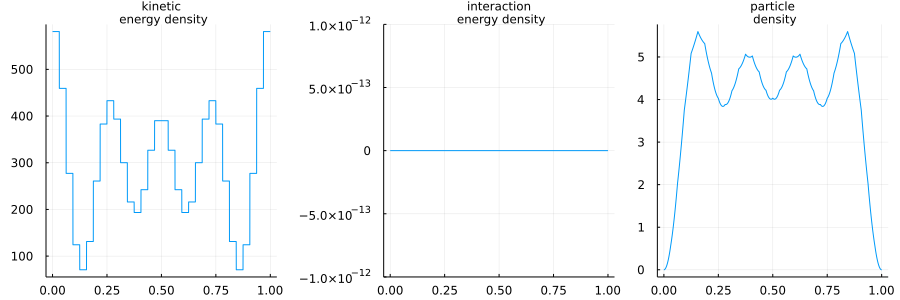

In [9]:
particle_density = expval(n̂, Ψ)
kinetic_energy_density = expval(k̂, Ψ)
interaction_energy_density = expval(û, Ψ);# plot densities
plotgrid = 0:1/3200:1;
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="", title="kinetic\n energy density")
p2 = plot(plotgrid, interaction_energy_density.(plotgrid), label="", ylims=(-1e-12,1e-12), title="interaction\n energy density")
p3 = plot(plotgrid, particle_density.(plotgrid), label="", title="particle\n density")
plot(p1, p2, p3, layout = (1,3), titlefontsize = 8, size = (900, 300))

As we can see, the interaction energy of the Tonks-Girardeau state is zero. All the energy is in the kinetic energy, and it is given by the sum of the `N` lowest single particle energies, which we used to construct the state. As we have represented the single particle wavefunctions using a piecewise linear approximation, the resulting kinetic energy is discontinuous and consists of piecewise constant elements. In generic finite cMPS simulations below, there will be additional contributions to the kinetic energy, but the discontinuities resulting from differentiating piecewise linear functions will remain.

In [10]:
E = expval(Ĥ₀(g = 1e6), Ψ)
Ekin = ∫(kinetic_energy_density, (a,b));
(E, Ekin)

(298.9066199350959, 298.9066199350959)

In [11]:
Ekin_exact = sum((π/(b-a)*n)^2 for n=1:N) # sum of single particle energies

296.08813203268073

This discrepancy is due to the coarseness of the grid.

In [12]:
K̂ = ∫(k̂, (a, b))
println(expval(K̂, tonksgirardeau(N, 0:1/32:1)) - Ekin_exact);
println(expval(K̂, tonksgirardeau(N, 0:1/64:1)) - Ekin_exact);
println(expval(K̂, tonksgirardeau(N, 0:1/128:1)) - Ekin_exact);

2.818487902415143
0.7023302737601398
0.17543728732272257


The error converges at a rate of $O(\Delta x^2)$ in the spacing $\Delta x$ of the grid.

## Variational optimization

To use variational optimization, we need to add a chemical potential, otherwise the lowest energy state is the vacuum with zero energy. We cannot directly target a given particle number in the current cMPS ansatz (unless with a Lagrange parameter, which is exactly the chemical potential).

In [13]:
# Hamiltonian with chemical potential
Ĥ₁(; g, μ) = Ĥ₀(g = g) - μ*N̂;

We build an initial cMPS with $D=8$ from which we will start the optimization. For $Q(x)$, we use a random constant matrix, whereas for $R(x)$ we use a random constant matrix multiplied with a standing wave ($\sin$ function) to satisfy the boundary conditions $R(a) = R(b) = 0$.

In [14]:
D = 8 # bond dimension
T = Float64 # scalar type
grid = 0:1/32:1 # still using the same grid as before
Q₀ = randn(T, (D,D))
R₀ = randn(T, (D,D))
Q = PiecewiseLinear(grid, [Q₀ for x in grid])
R = PiecewiseLinear(grid, [R₀*sin(π*(x-a)/(b-a)) for x in grid])
vL = setindex!(zeros(T, D), 1, 1)
vR = setindex!(zeros(T, D), 1, 1)
Ψ₀ = FiniteCMPS(Q, R, vL, vR);

We define a function to plot the different contributions to the energy density during the course of the optimization algorithm. As this depends on the value of $\mu$ and $g$, we make a function that returns the proper plot function to be passed to the optimization algorithm.

In [15]:
function plotresults₁(; μ, g, plotgrid = 0:1/3200:1, frequency = 10)
    function callback(numiter, E, normgrad, Ψ, ρL, ρR, e)
        if mod(numiter, frequency) == 0 # only plot results for certain iterations, as this would otherwise slow down
            IJulia.clear_output(true)
            kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
            interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
            particle_density = expval(n̂, Ψ, ρL, ρR)
            N = ∫(particle_density, (a, b))
            potential_energy_density = -μ*particle_density
            total_energy_density = e;
            p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="kinetic")
            plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
            plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
            plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
            plot!(p1, title = "iteration $numiter\n energy densities (E = $E)")
            p2 = plot(plotgrid, particle_density.(plotgrid), label="", title="gradient norm = $normgrad \n particle density (N = $N)")
            display(plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (800, 400)))
        end
    end
    return callback
end

plotresults₁ (generic function with 1 method)

We will be be looking for the optimal finite cMPS approximation to the ground state at $g=1e6$ with $N=4$ particles; choosing $\mu = (4.75\pi)^2$ as this value is in between the energy of the fourth and fifth energy eigenstates of a single particle in a box (standing waves).

In [16]:
μ = (4.75*π)^2
g = 1e6;

Optimizing directly at $g=1e6$ is however very challenging for gradient methods, and so we first optimize at a smaller value of $g$. We choose the LBFGS optimizer from OptimKit.jl and restrict the number of iterations to 1000. This is the first time the ground state routine runs and as it depends on several auxiliary methods, this call incurs some compilation overhead before starting the simulation.

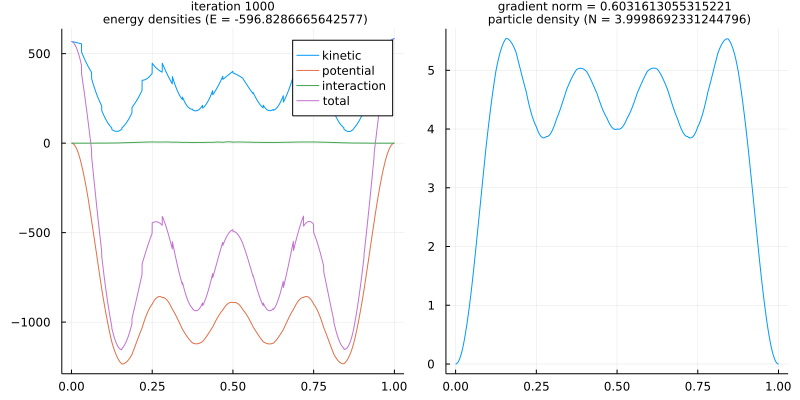

In [17]:
alg = LBFGS(80; maxiter = 1000)
Ψ, ρL, ρR, E, e, normgrad, numfg, history =
    groundstate(Ĥ₁(μ=μ, g=1e3), Ψ₀; optalg = alg, callback = plotresults₁(μ=μ, g=1e3));

Even for $g=10^3$, the result is not yet completely converged after 1000 iterations. For $g=10^6$, we easily need $O(10^6)$ iterations, though this can be mitigated by gradually increaging $g$ and by e.g. increasing the numbers of vectors kept in LBFGS. For convenience, however, we continue with an optimized cMPS that is loaded from disk.

Note that the `groundstate` routine not only returns the state, but also the matching reduced density matrices $\rho_L$ and $\rho_R$, as well as the total energy $E$ and energy density $e$. We can pass the density matrices along to `expval` so that they do not need to be recomputed when computing other expectation values. In the file loaded from disk, we have only stored the state to reduce storage needs. We can compute the environments with `environments!(Ψ)`, where the exclamation mark indicates that this function changes the argument (i.e., it normalizes the state). `environments!` takes keyword arguments `Kmax` and `tol` to control the required tolerance on the environments and the number of Taylor coefficients can be used. It returns the density matrices $\rho_L$ and $\rho_R$ together with two flags to indicate whether the requested tolerance was obtained.

In [18]:
optimisation = false; # change to `true` if you are very patient.
if optimisation
    Ψ₀ = Ψ
    alg = LBFGS(80; verbosity = 0, maxiter = 10^6, gradtol = 1e-3)
    Ψ, ρL, ρR, E, e, normgrad, numfg, history =
        groundstate(Ĥ₁(μ=μ, g=g), Ψ₀; optalg = alg, callback = plotresults₁(μ=μ, g=g));
else
    @load "FiniteCMPS_D=8_mu=223_g=1e6.jld" Ψ
    ρL, ρR, infoL, infoR = environments!(Ψ)
    E = expval(Ĥ₁(μ=μ, g=g), Ψ, ρL, ρR)
    e = expval(density(Ĥ₁(μ=μ, g=g)), Ψ, ρL, ρR)
end;
E

-594.4455915141801

For this state, we now also compute the local energy and particle densities.

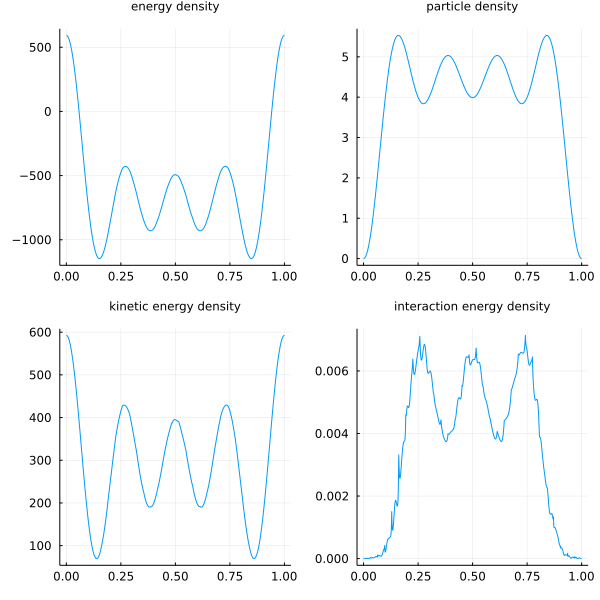

In [19]:
energy_density = e
particle_density = expval(n̂, Ψ, ρL, ρR)
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g*û, Ψ, ρL, ρR)
plotgrid = 0:1/3200:1
p1 = plot(plotgrid, energy_density.(plotgrid), label = "", title = "energy density")
p2 = plot(plotgrid, particle_density.(plotgrid), label = "", title="particle density")
p3 = plot(plotgrid, kinetic_energy_density.(plotgrid), label = "", title = "kinetic energy density")
p4 = plot(plotgrid, interaction_energy_density.(plotgrid), label="", title="interaction energy density")
plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 8, size = (600, 600))

Note that the interaction energy density now computed the factor $g=10^6$. This means that the expectation value $\langle \Psi| \hat{u}|\Psi\rangle$ itself is of the order of $10^{-9}$. In addition, we now compute the entanglement spectrum for a bipartition of the system in left and right at various positions $x$. Hereto, we need to compute the eigenvalues of $\rho_L^{1/2} \rho_R \rho_L^{1/2}$, which are the same of those of $\rho_L \rho_R$. We cannot directly compute the eigenvalues of `ρL*ρR`, which is a `Piecewise` object, but first evaluate it at a given position and then compute the eigenvalues. These will be returned as complex values (because `ρL*ρR` is not symmetric or hermitian), though the imaginary part is zero. We just take the real part and sort them in decreasing order. Using Julia's dot notation for broadcasting, we can do this for all the positions in `entanglement_grid`. Then, we can also compute the corresponding entanglement entropy (we use absolute value in the definition in order to avoid problems with tiny entanglement values which might have become negative due to finite machine precision).

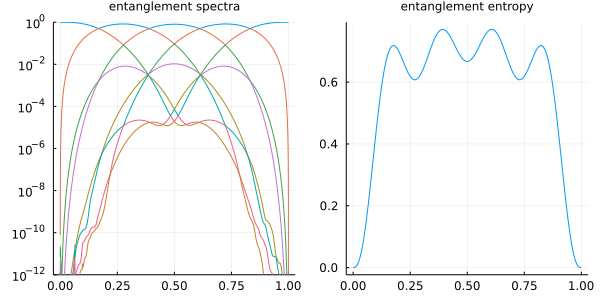

In [20]:
entanglement_grid = 0:1/3200:1
spectra = sort.(real.(eigvals.((ρL*ρR).(entanglement_grid))), rev=true)
spectra_reorganized = [collect(s[i] for s in spectra) for i = 1:D]
entropy(spectrum) = sum(-abs(p)*log(abs(p)) for p in spectrum)
p1 = plot(entanglement_grid, spectra_reorganized,  yscale = :log10, label="", ylim = (1e-12,1), title = "entanglement spectra")
p2 = plot(entanglement_grid, entropy.(spectra),  label="", title = "entanglement entropy")
plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (600, 300))

Finally, we revisit the particle number of this state. A generic cMPS represents a superposition of different particle numbers. In such a finite system, the exact ground state in the presence of a chemical potential (grand canonical ensemble at zero temperature) should nonetheless have a fixed particle number. We can investigate how well the finite cMPS with $D=8$ can reproduce this by measuring the fluctuations in the particle number:

In [21]:
(Q, (R,)) = Ψ
@show N = expval(N̂, Ψ, ρL, ρR);  # particle number expectation value
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2; # particle number variance

N = expval(N̂, Ψ, ρL, ρR) = 3.999880646605035
ΔN² = (2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2 = 0.000383895319126637


Hence, even with such a small bond dimension, the particle number fluctuations are very small.

## Inhomogeneous potential

We now study problems with an inhomogeneous potential $V(x)$. We hereto define a new Hamiltonian $\hat{H}_2$.

In [22]:
Ĥ₂(; g, μ, v) = Ĥ₁(;g = g, μ = μ) + ∫(v * ψ̂'*ψ̂, (a,b));

We consider a box with an external potential $V(x) \sim\sin(15\pi x)$, with $\mu = 1749$ and $g = 35$.

In [23]:
μ = 1749.
g = 35.
V(x) = sin(15*π*x)

V (generic function with 1 method)

We will find an optimal finite cMPS representation of the ground state with bond dimension $D=32$. To get a better initial state, we can first solve the homogeneous problem in the thermodynamic limit using infinite cMPS. We do not converge this to very high accuracy, as its only purpose is to build a slightly improved initial finite cMPS.

In [24]:
D = 32 # bond dimension
T = Float64 # scalar type
Q₀ = randn(T, (D,D))
R₀ = randn(T, (D,D))
Ψ∞ = InfiniteCMPS(Constant(Q₀), Constant(R₀))
Ĥ∞(; g, μ) = ∫(k̂ - μ * n̂ + g * û, (-Inf,+Inf));

In [25]:
alg = LBFGS(80; verbosity = 2, maxiter = 2000)
Ψ∞, ρL∞, ρR∞, E∞, e∞, normgrad, numfg, history = groundstate(Ĥ∞(g = g, μ = μ), Ψ∞; optalg = alg)

┌ Info: LBFGS: initializing with f = -17333.818930962545, ‖∇f‖ = 1.6667e+04
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:35
┌ Info: LBFGS: iter    1: f = -26799.920725355434, ‖∇f‖ = 6.6883e+03, α = 1.00e+00, m = 0, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter    2: f = -28819.897310316963, ‖∇f‖ = 3.2668e+03, α = 1.00e+00, m = 1, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter    3: f = -29397.954728096342, ‖∇f‖ = 2.1973e+03, α = 1.00e+00, m = 2, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter    4: f = -29684.083700443050, ‖∇f‖ = 1.6988e+03, α = 1.00e+00, m = 3, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter    5: f = -30022.564698698086, ‖∇f‖ = 1.9843e+03, α = 1.00e+00, m = 4, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter    6: f = -30648.328216567046, ‖∇f‖ =

┌ Info: LBFGS: iter   52: f = -33436.865090184830, ‖∇f‖ = 2.5075e+02, α = 1.00e+00, m = 51, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter   53: f = -33442.414727908137, ‖∇f‖ = 1.9331e+02, α = 1.00e+00, m = 52, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter   54: f = -33447.192817709496, ‖∇f‖ = 2.0961e+02, α = 1.00e+00, m = 53, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter   55: f = -33451.076219435839, ‖∇f‖ = 1.9407e+02, α = 1.00e+00, m = 54, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter   56: f = -33457.103622233386, ‖∇f‖ = 2.2594e+02, α = 1.00e+00, m = 55, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter   57: f = -33464.314856363941, ‖∇f‖ = 2.3927e+02, α = 1.00e+00, m = 56, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter   58: f 

┌ Info: LBFGS: iter  104: f = -33556.343672728814, ‖∇f‖ = 1.6116e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  105: f = -33558.619580999395, ‖∇f‖ = 1.0802e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  106: f = -33560.256182907542, ‖∇f‖ = 1.4411e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  107: f = -33561.113573545459, ‖∇f‖ = 1.0674e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  108: f = -33561.684476063623, ‖∇f‖ = 8.1374e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  109: f = -33562.601340629742, ‖∇f‖ = 6.0526e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  110: f 

┌ Info: LBFGS: iter  156: f = -33593.666036782888, ‖∇f‖ = 1.9797e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  157: f = -33596.553468583821, ‖∇f‖ = 2.1026e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  158: f = -33598.973268107788, ‖∇f‖ = 1.1288e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  159: f = -33600.006991485541, ‖∇f‖ = 9.6392e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  160: f = -33600.536630518851, ‖∇f‖ = 7.6468e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  161: f = -33600.966810300772, ‖∇f‖ = 6.0777e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  162: f 

┌ Info: LBFGS: iter  208: f = -33659.575936668189, ‖∇f‖ = 6.5025e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  209: f = -33660.207983293098, ‖∇f‖ = 7.5260e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  210: f = -33660.942401439861, ‖∇f‖ = 6.1843e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  211: f = -33661.900343652327, ‖∇f‖ = 8.1590e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  212: f = -33662.733080373728, ‖∇f‖ = 1.0450e+02, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  213: f = -33663.691435295907, ‖∇f‖ = 7.8065e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  214: f 

┌ Info: LBFGS: iter  260: f = -33711.931834480267, ‖∇f‖ = 6.2939e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  261: f = -33712.203783240962, ‖∇f‖ = 4.1280e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  262: f = -33712.435910758606, ‖∇f‖ = 3.9221e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  263: f = -33712.628494504912, ‖∇f‖ = 4.3145e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  264: f = -33712.838173287208, ‖∇f‖ = 3.4830e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  265: f = -33713.013001196246, ‖∇f‖ = 3.7173e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  266: f 

┌ Info: LBFGS: iter  312: f = -33720.469970514328, ‖∇f‖ = 4.3033e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  313: f = -33720.616946462105, ‖∇f‖ = 5.9526e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  314: f = -33720.766763668260, ‖∇f‖ = 3.0967e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  315: f = -33720.893444191490, ‖∇f‖ = 2.0916e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  316: f = -33720.992283479805, ‖∇f‖ = 2.0672e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  317: f = -33721.166823739142, ‖∇f‖ = 2.4957e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  318: f 

┌ Info: LBFGS: iter  364: f = -33735.114684616972, ‖∇f‖ = 8.4321e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  365: f = -33735.590320219562, ‖∇f‖ = 5.3595e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  366: f = -33736.203597977321, ‖∇f‖ = 5.7080e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  367: f = -33736.918971460254, ‖∇f‖ = 8.4265e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  368: f = -33737.661250860787, ‖∇f‖ = 9.5956e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  369: f = -33738.319276945578, ‖∇f‖ = 6.2591e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  370: f 

┌ Info: LBFGS: iter  416: f = -33749.936963903208, ‖∇f‖ = 2.0973e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  417: f = -33750.036379597659, ‖∇f‖ = 4.7778e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  418: f = -33750.167245828830, ‖∇f‖ = 2.8040e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  419: f = -33750.281327910474, ‖∇f‖ = 2.3959e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  420: f = -33750.481800796588, ‖∇f‖ = 3.5884e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  421: f = -33750.588606569756, ‖∇f‖ = 6.7685e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  422: f 

┌ Info: LBFGS: iter  468: f = -33754.948978057844, ‖∇f‖ = 3.4759e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  469: f = -33755.023442053571, ‖∇f‖ = 2.6352e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  470: f = -33755.157409294254, ‖∇f‖ = 2.0888e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  471: f = -33755.272770311021, ‖∇f‖ = 3.1659e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  472: f = -33755.389539796044, ‖∇f‖ = 2.6440e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  473: f = -33755.482945728443, ‖∇f‖ = 2.1564e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  474: f 

┌ Info: LBFGS: iter  520: f = -33758.500205268414, ‖∇f‖ = 1.9105e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  521: f = -33758.567800987686, ‖∇f‖ = 2.9032e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  522: f = -33758.622335205087, ‖∇f‖ = 1.6079e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  523: f = -33758.655058093820, ‖∇f‖ = 1.0813e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  524: f = -33758.710179421207, ‖∇f‖ = 1.2585e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  525: f = -33758.778243943867, ‖∇f‖ = 1.7570e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  526: f 

┌ Info: LBFGS: iter  572: f = -33762.427892260530, ‖∇f‖ = 4.5301e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  573: f = -33762.533473696487, ‖∇f‖ = 1.7650e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  574: f = -33762.593602656423, ‖∇f‖ = 1.4371e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  575: f = -33762.699320778891, ‖∇f‖ = 2.1944e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  576: f = -33762.772812370706, ‖∇f‖ = 4.8511e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  577: f = -33762.869680485797, ‖∇f‖ = 2.0141e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  578: f 

┌ Info: LBFGS: iter  624: f = -33770.102559119128, ‖∇f‖ = 7.1587e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  625: f = -33770.258106521243, ‖∇f‖ = 2.3060e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  626: f = -33770.320346510722, ‖∇f‖ = 1.8612e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  627: f = -33770.462634818949, ‖∇f‖ = 2.5761e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  628: f = -33770.668410233717, ‖∇f‖ = 2.8602e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  629: f = -33770.741161957725, ‖∇f‖ = 3.6962e+01, α = 3.91e-01, m = 80, nfg = 2
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  630: f 

┌ Info: LBFGS: iter  676: f = -33774.906925880874, ‖∇f‖ = 1.8454e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  677: f = -33775.018972466605, ‖∇f‖ = 2.3717e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  678: f = -33775.094479973974, ‖∇f‖ = 3.0978e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  679: f = -33775.181436845836, ‖∇f‖ = 2.4578e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  680: f = -33775.338735725985, ‖∇f‖ = 2.4060e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  681: f = -33775.427323650474, ‖∇f‖ = 3.8312e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  682: f 

┌ Info: LBFGS: iter  728: f = -33778.727316463533, ‖∇f‖ = 1.7369e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  729: f = -33778.809859768546, ‖∇f‖ = 3.5240e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  730: f = -33778.885516153699, ‖∇f‖ = 2.7475e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  731: f = -33778.952635623849, ‖∇f‖ = 1.4257e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  732: f = -33779.044749701286, ‖∇f‖ = 1.9223e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  733: f = -33779.129005264898, ‖∇f‖ = 2.8346e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  734: f 

┌ Info: LBFGS: iter  780: f = -33782.158838461168, ‖∇f‖ = 1.8112e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  781: f = -33782.231898608276, ‖∇f‖ = 2.3677e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  782: f = -33782.265201882161, ‖∇f‖ = 3.1617e+01, α = 3.97e-01, m = 80, nfg = 2
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  783: f = -33782.312864385691, ‖∇f‖ = 1.4984e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  784: f = -33782.347326943331, ‖∇f‖ = 1.0334e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  785: f = -33782.391292145498, ‖∇f‖ = 1.5090e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  786: f 

┌ Info: LBFGS: iter  832: f = -33784.749195387536, ‖∇f‖ = 1.4411e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  833: f = -33784.806905073914, ‖∇f‖ = 2.3852e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  834: f = -33784.823624168712, ‖∇f‖ = 5.2867e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  835: f = -33784.890689561311, ‖∇f‖ = 1.7205e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  836: f = -33784.918221482883, ‖∇f‖ = 1.0402e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  837: f = -33784.964197057801, ‖∇f‖ = 1.6297e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  838: f 

┌ Info: LBFGS: iter  884: f = -33787.172607734399, ‖∇f‖ = 1.1846e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  885: f = -33787.212160354880, ‖∇f‖ = 1.6799e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  886: f = -33787.265766154691, ‖∇f‖ = 1.5731e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  887: f = -33787.304163925983, ‖∇f‖ = 2.6583e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  888: f = -33787.338690442033, ‖∇f‖ = 1.2998e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  889: f = -33787.365416384251, ‖∇f‖ = 1.0725e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  890: f 

┌ Info: LBFGS: iter  936: f = -33789.171348023148, ‖∇f‖ = 1.0986e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  937: f = -33789.213500057602, ‖∇f‖ = 1.6179e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  938: f = -33789.243851334264, ‖∇f‖ = 1.9902e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  939: f = -33789.271987728811, ‖∇f‖ = 1.0416e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  940: f = -33789.309017514606, ‖∇f‖ = 1.0759e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  941: f = -33789.349939898013, ‖∇f‖ = 1.6574e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  942: f 

┌ Info: LBFGS: iter  988: f = -33790.341305675705, ‖∇f‖ = 1.2921e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  989: f = -33790.354626921762, ‖∇f‖ = 6.6770e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  990: f = -33790.372324518736, ‖∇f‖ = 6.7406e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  991: f = -33790.394486569341, ‖∇f‖ = 1.1124e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  992: f = -33790.417996258591, ‖∇f‖ = 2.0728e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  993: f = -33790.437883304890, ‖∇f‖ = 9.7206e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter  994: f 

┌ Info: LBFGS: iter 1040: f = -33791.247850808082, ‖∇f‖ = 7.9927e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1041: f = -33791.266290506836, ‖∇f‖ = 8.8353e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1042: f = -33791.279376674014, ‖∇f‖ = 1.9184e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1043: f = -33791.297641203113, ‖∇f‖ = 7.0251e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1044: f = -33791.310539458173, ‖∇f‖ = 6.2444e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1045: f = -33791.331878447134, ‖∇f‖ = 8.7671e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1046: f 

┌ Info: LBFGS: iter 1092: f = -33791.969073350483, ‖∇f‖ = 4.8373e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1093: f = -33791.991054826773, ‖∇f‖ = 9.1305e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1094: f = -33792.015706785591, ‖∇f‖ = 1.1740e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1095: f = -33792.033550686276, ‖∇f‖ = 1.5620e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1096: f = -33792.051269085256, ‖∇f‖ = 7.8223e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1097: f = -33792.063713504278, ‖∇f‖ = 6.8834e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1098: f 

┌ Info: LBFGS: iter 1144: f = -33793.148923742890, ‖∇f‖ = 1.0141e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1145: f = -33793.174147526544, ‖∇f‖ = 1.4837e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1146: f = -33793.199145410494, ‖∇f‖ = 1.1737e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1147: f = -33793.220877844447, ‖∇f‖ = 7.7971e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1148: f = -33793.246923954139, ‖∇f‖ = 8.9787e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1149: f = -33793.264813733709, ‖∇f‖ = 1.4231e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1150: f 

┌ Info: LBFGS: iter 1196: f = -33794.199467082901, ‖∇f‖ = 1.3900e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1197: f = -33794.225998660680, ‖∇f‖ = 1.2061e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1198: f = -33794.247541476259, ‖∇f‖ = 7.9326e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1199: f = -33794.270437674102, ‖∇f‖ = 1.0010e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1200: f = -33794.281507234366, ‖∇f‖ = 1.2472e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1201: f = -33794.290713773342, ‖∇f‖ = 6.3044e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1202: f 

┌ Info: LBFGS: iter 1248: f = -33795.016282388962, ‖∇f‖ = 1.0167e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1249: f = -33795.027458477351, ‖∇f‖ = 1.5617e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1250: f = -33795.041580185556, ‖∇f‖ = 5.5253e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1251: f = -33795.054016421484, ‖∇f‖ = 4.9421e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1252: f = -33795.077792899072, ‖∇f‖ = 1.1468e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1253: f = -33795.093620503409, ‖∇f‖ = 1.5201e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1254: f 

┌ Info: LBFGS: iter 1300: f = -33795.784102904654, ‖∇f‖ = 1.2776e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1301: f = -33795.794226085389, ‖∇f‖ = 8.9570e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1302: f = -33795.801954027454, ‖∇f‖ = 4.2609e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1303: f = -33795.815325577030, ‖∇f‖ = 6.0987e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1304: f = -33795.831869376518, ‖∇f‖ = 1.0397e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1305: f = -33795.840376350498, ‖∇f‖ = 1.2792e+01, α = 4.76e-01, m = 80, nfg = 2
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1306: f 

┌ Info: LBFGS: iter 1352: f = -33796.592889897656, ‖∇f‖ = 6.8391e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1353: f = -33796.613355606984, ‖∇f‖ = 1.0007e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1354: f = -33796.618657705294, ‖∇f‖ = 2.4995e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1355: f = -33796.640243658730, ‖∇f‖ = 6.9697e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1356: f = -33796.649407639801, ‖∇f‖ = 5.7395e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1357: f = -33796.665099573074, ‖∇f‖ = 6.9302e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1358: f 

┌ Info: LBFGS: iter 1404: f = -33797.545015744538, ‖∇f‖ = 2.4114e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1405: f = -33797.564604389539, ‖∇f‖ = 6.6487e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1406: f = -33797.573028760016, ‖∇f‖ = 4.4950e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1407: f = -33797.592372327126, ‖∇f‖ = 6.6558e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1408: f = -33797.613142584312, ‖∇f‖ = 8.8195e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1409: f = -33797.622690217060, ‖∇f‖ = 1.5758e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1410: f 

┌ Info: LBFGS: iter 1456: f = -33798.438311708131, ‖∇f‖ = 1.4713e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1457: f = -33798.456031254071, ‖∇f‖ = 7.8470e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1458: f = -33798.474073030207, ‖∇f‖ = 9.0464e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1459: f = -33798.498132544708, ‖∇f‖ = 1.3841e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1460: f = -33798.509178333232, ‖∇f‖ = 2.4499e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1461: f = -33798.527503775520, ‖∇f‖ = 9.1575e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1462: f 

┌ Info: LBFGS: iter 1508: f = -33799.453725335516, ‖∇f‖ = 9.7967e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1509: f = -33799.471745825664, ‖∇f‖ = 2.5031e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1510: f = -33799.498169803745, ‖∇f‖ = 1.0186e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1511: f = -33799.516644492920, ‖∇f‖ = 8.3515e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1512: f = -33799.553763735013, ‖∇f‖ = 1.0517e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1513: f = -33799.570910925329, ‖∇f‖ = 2.4972e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1514: f 

┌ Info: LBFGS: iter 1560: f = -33800.518018700044, ‖∇f‖ = 7.2551e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1561: f = -33800.536216554901, ‖∇f‖ = 7.6310e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1562: f = -33800.558928395963, ‖∇f‖ = 1.6276e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1563: f = -33800.579244080538, ‖∇f‖ = 1.0203e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1564: f = -33800.595922736931, ‖∇f‖ = 7.4154e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1565: f = -33800.615902798439, ‖∇f‖ = 9.6057e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1566: f 

┌ Info: LBFGS: iter 1612: f = -33801.320489427962, ‖∇f‖ = 9.8914e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1613: f = -33801.329594518960, ‖∇f‖ = 1.7361e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1614: f = -33801.343318071064, ‖∇f‖ = 6.4094e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1615: f = -33801.353248752974, ‖∇f‖ = 6.0574e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1616: f = -33801.367017122539, ‖∇f‖ = 7.9253e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1617: f = -33801.380743652146, ‖∇f‖ = 1.1159e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1618: f 

┌ Info: LBFGS: iter 1664: f = -33801.919534778928, ‖∇f‖ = 4.1126e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1665: f = -33801.934457324809, ‖∇f‖ = 7.5121e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1666: f = -33801.942363382477, ‖∇f‖ = 1.5784e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1667: f = -33801.952205635112, ‖∇f‖ = 5.5841e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1668: f = -33801.961824835475, ‖∇f‖ = 5.4543e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1669: f = -33801.974203580765, ‖∇f‖ = 7.7828e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1670: f 

┌ Info: LBFGS: iter 1716: f = -33802.520668023448, ‖∇f‖ = 1.0304e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1717: f = -33802.530002769898, ‖∇f‖ = 5.7370e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1718: f = -33802.539263071565, ‖∇f‖ = 6.2316e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1719: f = -33802.546976544909, ‖∇f‖ = 1.3120e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1720: f = -33802.552749588118, ‖∇f‖ = 5.5252e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1721: f = -33802.558122510192, ‖∇f‖ = 3.4791e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1722: f 

┌ Info: LBFGS: iter 1768: f = -33802.879370503571, ‖∇f‖ = 4.9235e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1769: f = -33802.883945743786, ‖∇f‖ = 3.5964e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1770: f = -33802.890020067985, ‖∇f‖ = 4.1766e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1771: f = -33802.895960006063, ‖∇f‖ = 7.6827e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1772: f = -33802.901795397571, ‖∇f‖ = 4.7162e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1773: f = -33802.906379145075, ‖∇f‖ = 2.6000e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1774: f 

┌ Info: LBFGS: iter 1820: f = -33803.164571708956, ‖∇f‖ = 2.8961e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1821: f = -33803.168276283614, ‖∇f‖ = 3.0826e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1822: f = -33803.176778050671, ‖∇f‖ = 6.3352e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1823: f = -33803.180708944405, ‖∇f‖ = 8.3098e+00, α = 5.47e-01, m = 80, nfg = 2
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1824: f = -33803.185072099339, ‖∇f‖ = 3.9210e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1825: f = -33803.190003078518, ‖∇f‖ = 2.3092e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1826: f 

┌ Info: LBFGS: iter 1872: f = -33803.560713641433, ‖∇f‖ = 5.6989e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1873: f = -33803.567481016406, ‖∇f‖ = 3.8087e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1874: f = -33803.581079121883, ‖∇f‖ = 6.4835e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1875: f = -33803.594063878118, ‖∇f‖ = 1.2978e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1876: f = -33803.605022544099, ‖∇f‖ = 9.2833e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1877: f = -33803.612860202280, ‖∇f‖ = 4.4335e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1878: f 

┌ Info: LBFGS: iter 1924: f = -33803.980538631644, ‖∇f‖ = 3.5557e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1925: f = -33803.985456373317, ‖∇f‖ = 2.7036e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1926: f = -33803.997180625236, ‖∇f‖ = 4.6055e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1927: f = -33804.002627813039, ‖∇f‖ = 1.4140e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1928: f = -33804.009878637313, ‖∇f‖ = 4.7715e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1929: f = -33804.015577163955, ‖∇f‖ = 4.1278e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1930: f 

┌ Info: LBFGS: iter 1976: f = -33804.295153469662, ‖∇f‖ = 4.3620e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1977: f = -33804.300564024496, ‖∇f‖ = 9.0768e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1978: f = -33804.305354659868, ‖∇f‖ = 4.2534e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1979: f = -33804.308543134961, ‖∇f‖ = 2.4990e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1980: f = -33804.313745816318, ‖∇f‖ = 3.4340e+00, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1981: f = -33804.315601258160, ‖∇f‖ = 1.1652e+01, α = 1.00e+00, m = 80, nfg = 1
└ @ OptimKit /Users/jutho/.julia/dev/OptimKit/src/lbfgs.jl:76
┌ Info: LBFGS: iter 1982: f 

(InfiniteCMPS{Constant{Matrix{Float64}}, 1}(Constant{Matrix{Float64}}(Base.RefValue{Matrix{Float64}}([-20.42533907826621 -12.002651814963771 … 1.0461237847834686 -10.662247964844923; 6.176028301312272 -18.60726975606245 … 9.211598377387338 2.9394189946676104; … ; 0.6784130710291383 7.396774599966604 … -25.7854718543047 -32.96517943014258; -3.1778828676957893 18.19471860414661 … 17.981827445247177 -41.08695680374816])), (Constant{Matrix{Float64}}(Base.RefValue{Matrix{Float64}}([-2.9307055051162343 2.2964431805958365 … 0.2135662595352116 -0.8593228491398563; 4.643994769961182 0.8536354647367839 … -0.20758555511101626 1.6823699387999511; … ; -0.26462864208998005 1.418936001652382 … 0.0026545340159713246 -0.19277932153122948; -0.25068690052998494 -0.5022286027592491 … 0.20576848590141592 3.303450733799522])),), :left), Constant{Matrix{Float64}}(Base.RefValue{Matrix{Float64}}([1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])), Constant{Matrix{Float64}}(Base.R

We now use the $Q$ and $R$ matrix of this infinite cMPS to initialize the finite cMPS. Note that all matrices are wrapped in the type `Constant`, which indicates that they are constant functions, and not, say, periodic functions represented as a `FourierSeries`. Also note that the resulting cMPS is in the left gauge. We transform it to a symmetric gauge where $\rho_L = \rho_R$ and are a diagonal matrix $\Lambda$.

In [26]:
Q∞, (R∞,) = Ψ∞
Q₀ = Q∞[]
R₀ = R∞[]
@show norm(Q₀ + Q₀' + R₀'*R₀) # test ρ_L = I
Σ, U = eigen(Hermitian(ρR∞[]); sortby=x->(-abs(x)))
Λ = Diagonal(sqrt.(Σ))
Q₀ = sqrt(Λ)\U'*Q₀*U*sqrt(Λ)
R₀ = sqrt(Λ)\U'*R₀*U*sqrt(Λ)
@show norm(Q₀*Λ + Λ*Q₀' + R₀*Λ*R₀') # test ρ_R = Λ
@show norm(Λ*Q₀ + Q₀'*Λ + R₀'*Λ*R₀); # test ρ_L = Λ

norm(Q₀ + Q₀' + R₀' * R₀) = 1.069611396496206e-11
norm(Q₀ * Λ + Λ * Q₀' + R₀ * Λ * R₀') = 1.1626947833730803e-10
norm(Λ * Q₀ + Q₀' * Λ + R₀' * Λ * R₀) = 7.624017088858616e-13


We also measure the particle density in this state:

In [27]:
n∞ = expval(n̂, Ψ∞);
@show n∞[];

n∞[] = 34.99841657212642


We now build a finite cMPS on a grid with $\Delta x = 10^{-2}$ by using $Q(x)=Q_0$ and $R(x)=R_0 f(x)$ with $f(a)=f(b) = 0$ and $f(x) \approx 1$ in the middle. Given that there will be $O(30)$ particles in the box of length $b-a = 1$, we should probably reach the bulk behaviour in a distance of about $\delta \approx 1/30$.

In [28]:
D = 32 # bond dimension
T = Float64 # scalar type
grid = 0:1/100:1
Q = PiecewiseLinear(grid, [Q₀ for x in grid])
δ = 1/30
R = PiecewiseLinear(grid, [R₀*ifelse(x<δ, x/δ, ifelse(1-x < δ, (1-x)/δ, 1.)) for x in grid])
vL = setindex!(zeros(T, D), 1, 1)
vR = setindex!(zeros(T, D), 1, 1)
Ψ₀ = FiniteCMPS(Q, R, vL, vR);

In order to use the inhomogeneous potential $V(x)$ in our groundstate algorithm, we also have to represent it as a `Piecewise` of `TaylorSeries` elements. 

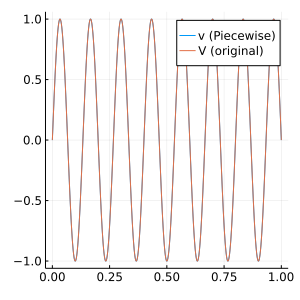

In [29]:
v = CMPSKit.Piecewise(grid, [fit(V, TaylorSeries, (grid[i],grid[i+1])) for i in 1:length(grid)-1])
# let's confirm this works
plot(plotgrid, [v.(plotgrid), V.(plotgrid)], label=["v (Piecewise)" "V (original)"], size = (300, 300))

We also adapt the callback function to plot the results during the optimisation.

In [30]:
function plotresults₂(; μ, v, g, plotgrid = 0:1/500:1, frequency = 1)
    function callback(numiter, E, normgrad, Ψ, ρL, ρR, e)
        if mod(numiter, frequency) == 0
            IJulia.clear_output(true)
            kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
            interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
            particle_density = expval(n̂, Ψ, ρL, ρR)
            N = ∫(particle_density, (a, b))
            potential_energy_density = expval((v - μ*one(v)) * n̂, Ψ, ρL, ρR)
            total_energy_density = e;
            p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="kinetic")
            plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
            plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
            plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
            plot!(p1, title = "iteration $numiter\n energy densities (E = $E)")
            p2 = plot(plotgrid, particle_density.(plotgrid), label="", title="gradient norm = $normgrad \n particle density (N = $N)")
            display(plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (800, 400)))
        end
    end
    return callback
end

plotresults₂ (generic function with 1 method)

We now compute the finite cMPS ground state approximation for three different values of $V(x)$ with increasing modulation strength, namely $V_1(x) = \frac{\mu}{4} \sin(15 \pi x)$, $V_2(x) = \frac{\mu}{2} \sin(15 \pi x)$ and $V_3(x) = \mu \sin(15 \pi x)$. For $V_1(x)$, we use $\Psi_0$ as an initial guess. For the next values of $V(x)$, we can use the previous result. In a few 100 iterations, the result are already qualitatively good.

In [31]:
v₁ = μ/4*v
v₂ = μ/2*v
v₃ = μ*v;

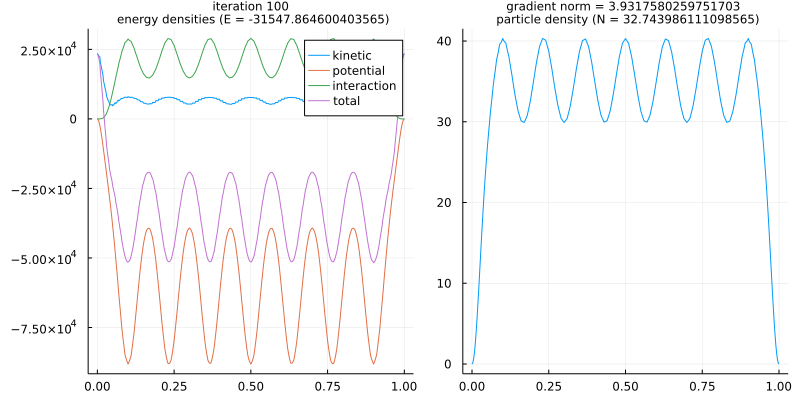

In [32]:
alg = LBFGS(50; maxiter = 100)
Ψ₁, ρL₁, ρR₁, E₁, e₁ =
    groundstate(Ĥ₂(μ = μ, v = v₁, g = g), Ψ₀; optalg = alg, callback = plotresults₂(μ = μ, g = g, v = v₁));

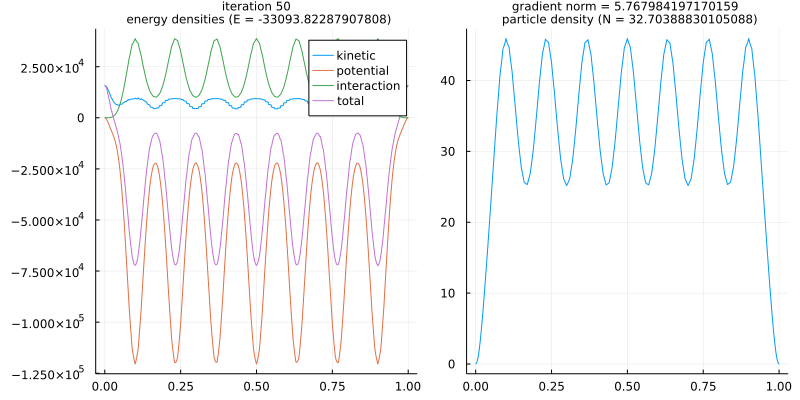

In [33]:
alg = LBFGS(50; maxiter = 50)
Ψ₂, ρL₂, ρR₂, E₂, e₂ =
    groundstate(Ĥ₂(μ = μ, v = v₂, g = g), Ψ₁; optalg = alg, callback = plotresults₂(μ = μ, g = g, v = v₂));

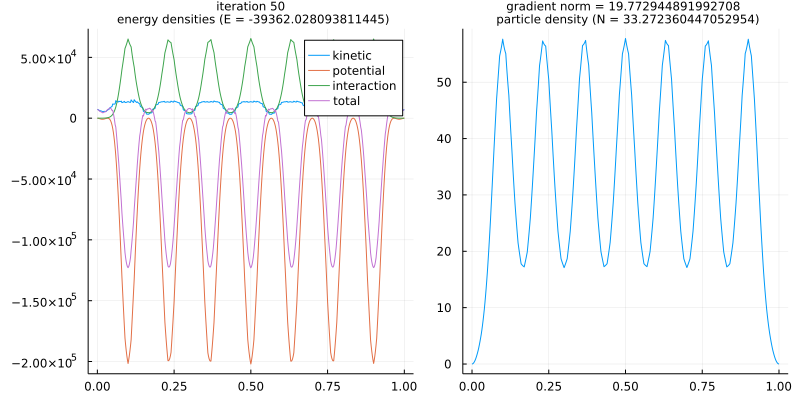

In [34]:
alg = LBFGS(50; maxiter = 50)
Ψ₃, ρL₃, ρR₃, E₃, e₃ =
    groundstate(Ĥ₂(μ = μ, v = v₃, g = g), Ψ₂; optalg = alg, callback = plotresults₂(μ = μ, g = g, v = v₃));

To proceed, we can load better converged results from disk, though this is not strictly necessary. Note that they are a bit smoother and have a slightly lower energy, but more significantly that they have a better converged total particle number and thus less particle number fluctuations.

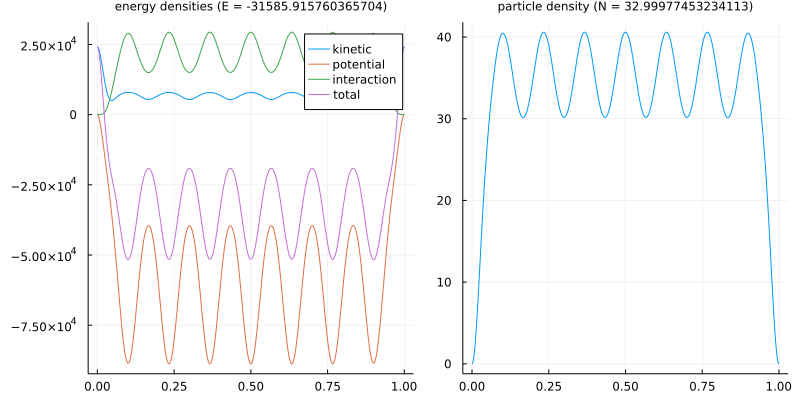

In [35]:
@load "FiniteCMPS_D=32_mu=1749_g=35_v=437sin.jld" Ψ
ρL, ρR, = environments!(Ψ)
total_energy_density = expval(density(Ĥ₂(μ = μ, v = v₁, g = g)), Ψ, ρL, ρR)
E = ∫(total_energy_density, (a, b))
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
particle_density = expval(n̂, Ψ, ρL, ρR)
N = ∫(particle_density, (a, b))
potential_energy_density = expval((v₁ - μ*one(v₁)) * n̂, Ψ, ρL, ρR)
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="kinetic")
plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
plot!(p1, title = "energy densities (E = $E)")
p2 = plot(plotgrid, particle_density.(plotgrid), label="", title="particle density (N = $N)")
display(plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (800, 400)))
Ψ₁, ρL₁, ρR₁, E₁, e₁, n₁ = Ψ, ρL, ρR, E, total_energy_density, particle_density;

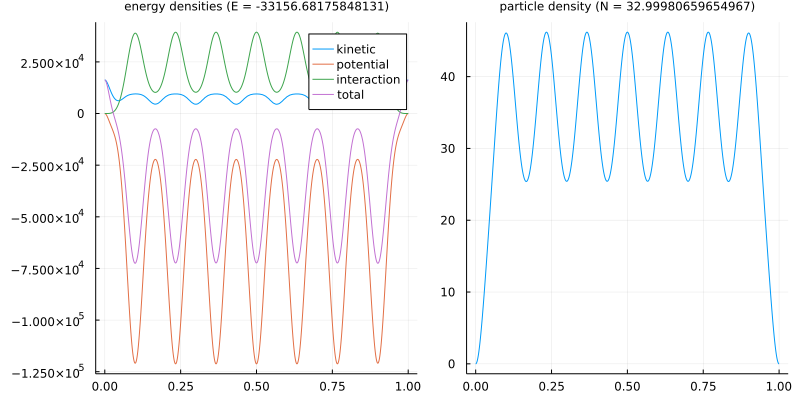

In [36]:
@load "FiniteCMPS_D=32_mu=1749_g=35_v=874sin.jld" Ψ
ρL, ρR, = environments!(Ψ)
total_energy_density = expval(density(Ĥ₂(μ = μ, v = v₂, g = g)), Ψ, ρL, ρR)
E = ∫(total_energy_density, (a, b))
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
particle_density = expval(n̂, Ψ, ρL, ρR)
N = ∫(particle_density, (a, b))
potential_energy_density = expval((v₂ - μ*one(v₂)) * n̂, Ψ, ρL, ρR)
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="kinetic")
plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
plot!(p1, title = "energy densities (E = $E)")
p2 = plot(plotgrid, particle_density.(plotgrid), label="", title="particle density (N = $N)")
display(plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (800, 400)))
Ψ₂, ρL₂, ρR₂, E₂, e₂, n₂ = Ψ, ρL, ρR, E, total_energy_density, particle_density;

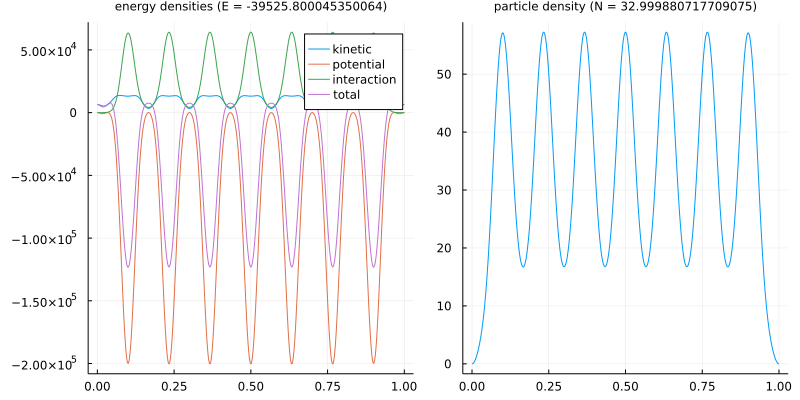

In [37]:
@load "FiniteCMPS_D=32_mu=1749_g=35_v=1749sin.jld" Ψ
ρL, ρR, = environments!(Ψ)
total_energy_density = expval(density(Ĥ₂(μ = μ, v = v₃, g = g)), Ψ, ρL, ρR)
E = ∫(total_energy_density, (a, b))
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
particle_density = expval(n̂, Ψ, ρL, ρR)
N = ∫(particle_density, (a, b))
potential_energy_density = expval((v₃ - μ*one(v₃)) * n̂, Ψ, ρL, ρR)
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="kinetic")
plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
plot!(p1, title = "energy densities (E = $E)")
p2 = plot(plotgrid, particle_density.(plotgrid), label="", title="particle density (N = $N)")
display(plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (800, 400)))
Ψ₃, ρL₃, ρR₃, E₃, e₃, n₃ = Ψ, ρL, ρR, E, total_energy_density, particle_density;

## Bethe ansatz and local density approximation

We now want to compare these density profiles to those predicted by applying the local density approximation to the Bethe ansatz results in the thermodynamic limit. Hereto, we have to solve the Bethe equations, which are given in terms of a parameter $q$ by an integral equation

$$\rho(k) = \frac{1}{2\pi} - \frac{1}{2\pi}\int_{-q}^{+q} K(g, k, k^\prime) \rho(k^\prime) d k^\prime$$

with the kernel $K$ given by

$$K(g, k, k^\prime) = \frac{-2g}{g^2 + (k-k^\prime)^2}$$

(see e.g. Eq. 2.42 in https://arxiv.org/pdf/1609.02100.pdf).

We can then compute the corresponding particle density

$$ n = \int_{-q}^{+q} \rho(k) d k$$

and energy density

$$ e = \int_{-q}^{+q} k^2 \rho(k) d k $$

and eliminate $q$ to find $e$ in terms of $n$. Note that the Bethe energy $e(q)$ only contains the contribution of the kinetic and interaction energy, and not that of the potential energy. In the ensemble of fixed particle number, we can compute the chemical potential as

$$ \mu = \frac{d e}{d n} = (\frac{d e}{d q}) / (\frac{d n}{d q}).$$

Alternatively, for a given $\mu$, we can directly find $q$ which minimizes $e(q) - \mu n(q)$ which results in the same equation.

To compute the derivatives $\frac{d n}{d q}$ and $\frac{d e}{d q}$, we compute $\frac{ d \rho}{d q}(k)$, which is similarly defined by the integral equation

$$\frac{ d \rho}{d q}(k) = K(g, k, q)  \frac{\rho(q)}{2\pi} + K(g, k, -q) \frac{\rho(-q)}{2\pi} +  \frac{1}{2\pi}\int_{-q}^{+q} K(g, k, k^\prime) \frac{ d \rho}{d q}(k^\prime) d k^\prime.$$

We solve these integral equations by discretising the $k$-interval $(-q, q)$ in $N$ segments, using the most naive form of numerical integration (midpoint rule). 

In [38]:
kernel(g, k, k′) = -2*g/(g^2+(k-k′)^2)
function bethe(g, q; N = 100)
    if iszero(q)
        return 0., 0., 1/pi, 0.
    end
    dk = 2*q/N
    kgrid = range(-q, stop = q, length = N+1)
    dkgrid = dk*vcat([0.5], ones(Float64, N-1), [0.5])
    M = I + (kernel.(g, kgrid, kgrid') .* dkgrid')/(2π)
    ρ = M\(ones(Float64, N+1)/(2π))
    dρ = M\((-1/(2π)) .* (kernel.(g, kgrid, q) .* ρ[N] .+ kernel.(g, kgrid, -q) .* ρ[1]))
    e = sum(kgrid.^2 .* ρ .* dkgrid)
    de = q^2*ρ[end] + q^2*ρ[1] + sum(kgrid.^2 .* dρ .* dkgrid)
    n = sum(ρ .* dkgrid)
    dn = ρ[end] + ρ[1] + sum(dρ .* dkgrid)
    return n, e, dn, de
end

bethe (generic function with 1 method)

We now compute the result of the `bethe` function for a range of `q` values, sufficiently big such that the resulting chemical potentials range from $0$ to $2\mu$ with $\mu = 1749$, which is what we will need to be able to apply the local density approximation to our local values of the chemical potential $\mu - V(x)$.

In [39]:
qgrid = range(0, stop = 75, length = 1000)
n_bethe = zeros(Float64, length(qgrid))
e_bethe = zeros(Float64, length(qgrid))
dn_bethe = zeros(Float64, length(qgrid))
de_bethe = zeros(Float64, length(qgrid))
for (i, q) in enumerate(qgrid)
    n_bethe[i], e_bethe[i], dn_bethe[i], de_bethe[i] = bethe(g, q)
end
μ_bethe = de_bethe ./ dn_bethe;
@show maximum(μ_bethe) > 2*μ;

maximum(μ_bethe) > 2μ = true


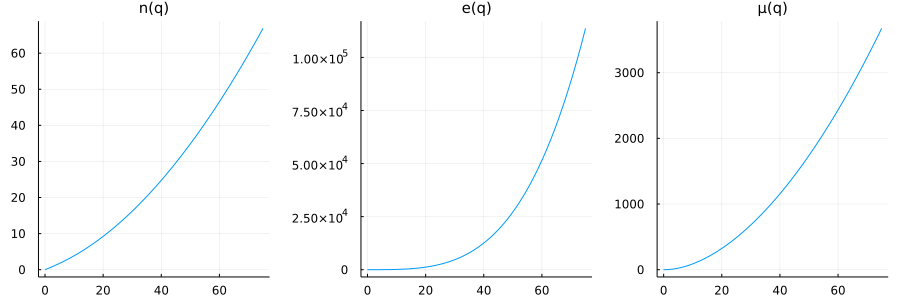

In [40]:
p1 = plot(qgrid, n_bethe, title = "n(q)", titlefontsize=10, labels = "")
p2 = plot(qgrid, e_bethe, title = "e(q)", titlefontsize=10, labels = "")
p3 = plot(qgrid, μ_bethe, title = "μ(q)", titlefontsize=10, labels = "")
plot(p1, p2, p3, layout = (1,3), size = (900, 300))

As in particular $\mu$ is a monotonically increasing array, we can easily eliminate $q$ and obtain the particle and energy density as a function of the chemical potential by using linear interpolation. We define

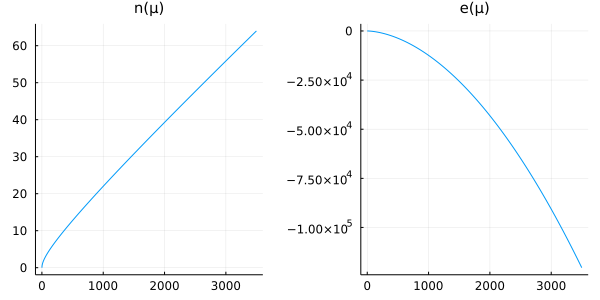

In [41]:
particle_density_bethe = PiecewiseLinear(μ_bethe, n_bethe)
energy_density_bethe = PiecewiseLinear(μ_bethe, e_bethe .- μ_bethe .* n_bethe)
μ_range = range(0, stop = 2*μ, length = 1000)
p1 = plot(μ_range, particle_density_bethe.(μ_range), title = "n(μ)", titlefontsize=10, labels = "")
p2 = plot(μ_range, energy_density_bethe.(μ_range), title = "e(μ)", titlefontsize=10, labels = "")
plot(p1, p2, layout = (1, 2), size = (600, 300))

We can compare the Bethe ansatz result with our infinite cMPS result:

In [42]:
@show particle_density_bethe(μ), n∞[]
@show energy_density_bethe(μ), e∞[];

(particle_density_bethe(μ), n∞[]) = (35.02680114597097, 34.99841657212642)
(energy_density_bethe(μ), e∞[]) = (-33805.50930388995, -33804.38785105305)


The infinite cMPS result is (sometimes, depending on the random initial guess) a bit lower in energy, which seems to be in violation of the variational principle. This is caused, not by an error in the linear interpolation (as $e(\mu)$ is concave), but because of the approximation of the integral in the Bethe equations. Indeed, we can find the optimal $q$ for given $\mu$ by minimizing $e(q) - \mu n(q)$ as outlined above, and now use a higher value of $N$, the number of points in the midpoint approximation to the integral. Practically, we find $q$ by finding the zero of $\frac{d e}{d q} - \mu \frac{d n}{d q}$ using a simple secant method.

In [43]:
q_guess = PiecewiseLinear(μ_bethe, collect(qgrid))(μ)
q_a = q_guess - 0.1
n_a, e_a, dn_a, de_a = bethe(g, q_a; N = 2000)
q_b = q_guess + 0.1
n_b, e_b, dn_b, de_b = bethe(g, q_b; N = 2000)
@show grad_a = de_a - μ * dn_a
@show grad_b = de_b - μ * dn_b
i = 1
q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
n_c, e_c, dn_c, de_c = bethe(g, q_c; N = 2000)
grad_c = de_c - μ * dn_c
println("Secant iteration $i: de_c - μ * dn_c = $grad_c")

grad_a = de_a - μ * dn_a = -5.010515887885276
grad_b = de_b - μ * dn_b = 9.006599199174389
Secant iteration 1: de_c - μ * dn_c = -0.014559833710563908


In [44]:
while abs(grad_c) > 1e-12
    i += 1
    if grad_c < 0
        q_a = q_c
        grad_a = grad_c
    else
        q_b = q_c
        grad_b = grad_c
    end
    q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
    n_c, e_c, dn_c, de_c = bethe(g, q_c; N= 2000)
    grad_c = de_c - μ * dn_c
    println("Secant iteration $i: de_c - μ * dn_c = $grad_c")
end

Secant iteration 2: de_c - μ * dn_c = -4.2186816017419915e-5
Secant iteration 3: de_c - μ * dn_c = -1.222347236762289e-7
Secant iteration 4: de_c - μ * dn_c = -3.537934389896691e-10
Secant iteration 5: de_c - μ * dn_c = -1.5916157281026244e-12
Secant iteration 6: de_c - μ * dn_c = 4.547473508864641e-13


In [45]:
@show e_c - μ*n_c, e∞[];
@show n_c, n∞[];

(e_c - μ * n_c, e∞[]) = (-33811.374379066714, -33804.38785105305)
(n_c, n∞[]) = (34.99770748796797, 34.99841657212642)


Problem solved: in fact, the infinite cMPS result was still a bit too high, which can be a result of finite bond dimension $D$, but also because it was not fully converged at the current bond dimension either.

We now compare the inhomogeneous results obtained with the finite cMPS to a local density approximation applied to the Bethe ansatz, i.e. we assume that the local energy density $e(x)$ and $n(x)$ is just that of the thermodynamic limit Bethe ansatz result corresponding to a chemical potential $\mu(x) = \mu - V(x)$.

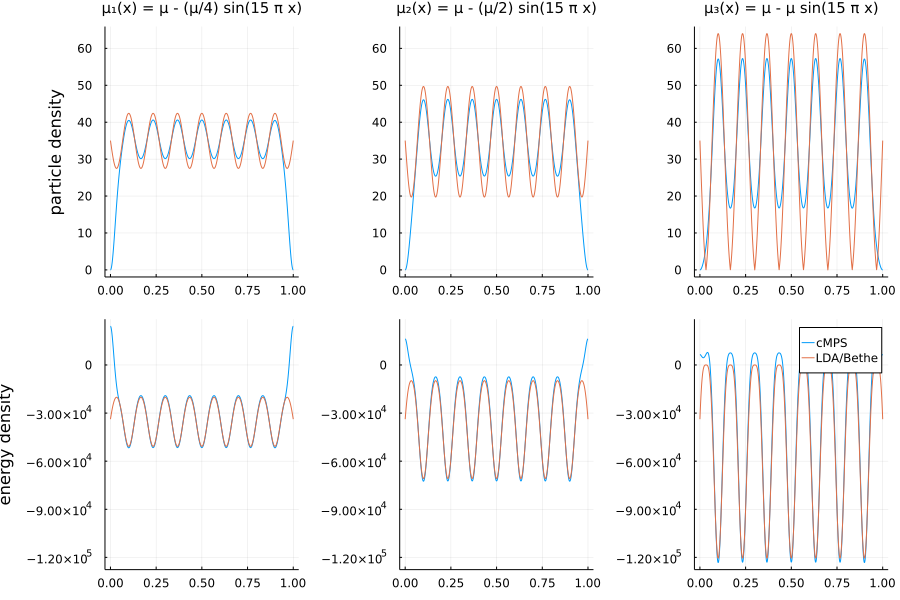

In [46]:
μ₁(x) = μ - v₁(x)
μ₂(x) = μ - v₂(x)
μ₃(x) = max(μ - v₃(x), 0.) # can become slightly negative due to floating point errors
p1 = plot(plotgrid, [n₁.(plotgrid) particle_density_bethe.(μ₁.(plotgrid))], labels = "", yguide="particle density", title = "μ₁(x) = μ - (μ/4) sin(15 π x)", titlefontsize = 10)
p2 = plot(plotgrid, [n₂.(plotgrid) particle_density_bethe.(μ₂.(plotgrid))], labels = "", title = "μ₂(x) = μ - (μ/2) sin(15 π x)", titlefontsize = 10)
p3 = plot(plotgrid, [n₃.(plotgrid) particle_density_bethe.(μ₃.(plotgrid))], labels = "", title = "μ₃(x) = μ - μ sin(15 π x)", titlefontsize = 10)
p4 = plot(plotgrid, [e₁.(plotgrid) energy_density_bethe.(μ₁.(plotgrid))], labels = "", yguide="energy density")
p5 = plot(plotgrid, [e₂.(plotgrid) energy_density_bethe.(μ₂.(plotgrid))], labels = "")
p6 = plot(plotgrid, [e₃.(plotgrid) energy_density_bethe.(μ₃.(plotgrid))], labels = ["cMPS" "LDA/Bethe"])
plot(p1, p2, p3, p4, p5, p6, layout = (2, 3), link=:both, size = (900, 600))

We see that the local density approximation (LDA) is quite good away from the boundaries for the energy density in the case of $V_1(x)$ and $V_2(x)$ which are sufficiently smaller than the chemical potential (though the particle density prediction has already significant errors). In the case $V_3(x)$, both energy and particle density cannot be captured by the LDA.

## Casimir energy

As a final example, we calculate the boundary or Casimir energy of such an interacting Bose gas. We therefore study the system in a box of length $L = 1$ with $V(x) = 0$, $μ = 10000$ and $g = 1000$ using a cMPS with $D = 64$ and a grid of 300 intervals (with an inhomogeneous distribution of the grid points such that there are more points in the bulk of the system). We first find the corresponding infinite cMPS describing this system in the thermodynamic limit. Again we can load a preconverged result from disk.

In [47]:
g = 1000.
μ = 10000.
D = 64 # bond dimension
T = Float64 # scalar type
optimisation = false
if optimisation
    Q₀ = randn(T, (D,D))
    R₀ = randn(T, (D,D))
    Ψ∞ = InfiniteCMPS(Constant(Q₀), Constant(R₀))
    alg = LBFGS(80; verbosity = 2, maxiter = 2000)
    Ψ∞, ρL∞, ρR∞, E∞, e∞, normgrad, numfg, history = groundstate(Ĥ∞(g = g, μ = μ), Ψ∞; optalg = alg)
else
    @load "InfiniteCMPS_D=64_mu=10000_g=1000.jld" Ψ∞
    ρL∞, ρR∞ = environments!(Ψ∞)
    e∞ = expval(density(Ĥ∞(g = g, μ = μ)), Ψ∞, ρL∞, ρR∞)
    E∞ = e∞[]
end
n∞ = expval(n̂, Ψ∞, ρL∞, ρR∞)
@show e∞[], n∞[];

(e∞[], n∞[]) = (-226719.87853564203, 34.783714995891685)


Let's compare this to the Bethe ansatz result. We again run our secant algorithm, now for $g = 1000$ and using a very wide initial interval.

In [48]:
q_a = 0
n_a, e_a, dn_a, de_a = bethe(g, q_a; N = 2000)
q_b = 200
n_b, e_b, dn_b, de_b = bethe(g, q_b; N = 2000)
@show grad_a = de_a - μ * dn_a
@show grad_b = de_b - μ * dn_b
i = 1
q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
n_c, e_c, dn_c, de_c = bethe(g, q_c; N = 2000)
grad_c = de_c - μ * dn_c
println("Secant iteration $i: de_c - μ * dn_c = $grad_c")
while abs(grad_c) > 1e-9
    i += 1
    if grad_c < 0
        q_a = q_c
        grad_a = grad_c
    else
        q_b = q_c
        grad_b = grad_c
    end
    q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
    n_c, e_c, dn_c, de_c = bethe(g, q_c; N= 2000)
    grad_c = de_c - μ * dn_c
    println("Secant iteration $i: de_c - μ * dn_c = $grad_c")
end
n_bethe = n_c;
e_bethe = e_c;

grad_a = de_a - μ * dn_a = -3183.098861837907
grad_b = de_b - μ * dn_b = 11031.012526424172
Secant iteration 1: de_c - μ * dn_c = -2708.554097809087
Secant iteration 2: de_c - μ * dn_c = -1578.459442626081
Secant iteration 3: de_c - μ * dn_c = -730.1310912609765
Secant iteration 4: de_c - μ * dn_c = -302.31314085421127
Secant iteration 5: de_c - μ * dn_c = -119.45735260237416
Secant iteration 6: de_c - μ * dn_c = -46.3319800132449
Secant iteration 7: de_c - μ * dn_c = -17.840272341963555
Secant iteration 8: de_c - μ * dn_c = -6.850284763792843
Secant iteration 9: de_c - μ * dn_c = -2.627541528278016
Secant iteration 10: de_c - μ * dn_c = -1.0074226381057088
Secant iteration 11: de_c - μ * dn_c = -0.3861937547890193
Secant iteration 12: de_c - μ * dn_c = -0.14803775749624037
Secant iteration 13: de_c - μ * dn_c = -0.05674527061273693
Secant iteration 14: de_c - μ * dn_c = -0.021751188011876366
Secant iteration 15: de_c - μ * dn_c = -0.008337480141108244
Secant iteration 16: de_c - μ * d

In [49]:
@show e_bethe - μ*n_bethe, e∞[];
@show n_bethe, n∞[];
@show γ = g/n_bethe;

(e_bethe - μ * n_bethe, e∞[]) = (-226721.3172439935, -226719.87853564203)
(n_bethe, n∞[]) = (34.78393917641078, 34.783714995891685)
γ = g / n_bethe = 28.748900316562306


Note that a generic cMPS, in particular an infinite cMPS, is similar to a coherent state in that it discribes a superposition over different particle numbers. It does thus not have a fixed paricle number, i.e. it breaks the $\mathsf{U}_1$ particle number symmetry, and has a nonzero expectation value for the order parameter $\langle \hat{\psi}\rangle$ corresponding to Bose-Einstein condensation. This is different for the exact solution, which has no total particle number flucutations even in the thermodynamic limit, and thus a zero value for the order parameter, i.e. there is no Bose-Einstein condensation in one spatiatl dimension. We can measure the order parameter for the optimal cMPS and find that it is quite large (though it should be measured relative to the square root of the density to have an intrinsic value); breaking the global $\mathsf{U}_1$ symmetry helps significantly to reduce the entanglement but has little effect on the local properties of the state:

In [50]:
@show bec_order∞ = expval(ψ̂, Ψ∞, ρL∞, ρR∞)[];
@show relative_bec_order∞ = bec_order∞ / sqrt(n∞[]);

bec_order∞ = (expval(ψ̂, Ψ∞, ρL∞, ρR∞))[] = 1.5282840611606487
relative_bec_order∞ = bec_order∞ / sqrt(n∞[]) = 0.25912904935496567


Now we compute the corresponding finite cMPS approximation for the Bose gas in the box. We can again use the infinite result to construct a slightly better initial guess. Nonetheless, we recommend using the converged result from disk, as this optimisation requires a large number of iterations and can thus take several days or weeks.

In [51]:
optimisation = false
if optimisation
    Q∞, (R∞,) = Ψ∞
    Q₀ = Q∞[]
    R₀ = R∞[]
    Σ, U = eigen(Hermitian(ρR∞[]); sortby=x->(-abs(x)))
    Λ = Diagonal(sqrt.(Σ))
    Q₀ = sqrt(Λ)\U'*Q₀*U*sqrt(Λ)
    R₀ = sqrt(Λ)\U'*R₀*U*sqrt(Λ)
    N = 300
    krange = range(0.,stop = 1.,length = N+1);
    grid = (1 .- cos.(krange .* pi)) ./ 2
    Q = PiecewiseLinear(grid, [Q₀ for x in grid])
    δ = 1/30
    R = PiecewiseLinear(grid, [R₀*ifelse(x<δ, x/δ, ifelse(1-x < δ, (1-x)/δ, 1.)) for x in grid])
    vL = setindex!(zeros(T, D), 1, 1)
    vR = setindex!(zeros(T, D), 1, 1)
    Ψ₀ = FiniteCMPS(Q, R, vL, vR);    
    alg = LBFGS(50; maxiter = 10^6)    
    Ψ, ρL, ρR, E, e, normgrad, numfg, history =
        groundstate(Ĥ₁(μ=μ, g=g), Ψ₀; optalg = alg, callback = plotresults₁(μ=μ, g=g; frequency = 1));
else
    @load "FiniteCMPS_D=64_mu=10000_g=1000.jld" Ψ
    ρL, ρR = environments!(Ψ)
    E = expval(Ĥ₁(μ=μ, g=g), Ψ, ρL, ρR)
end;

As before, we plot the particle density and different contributions to the energy density.

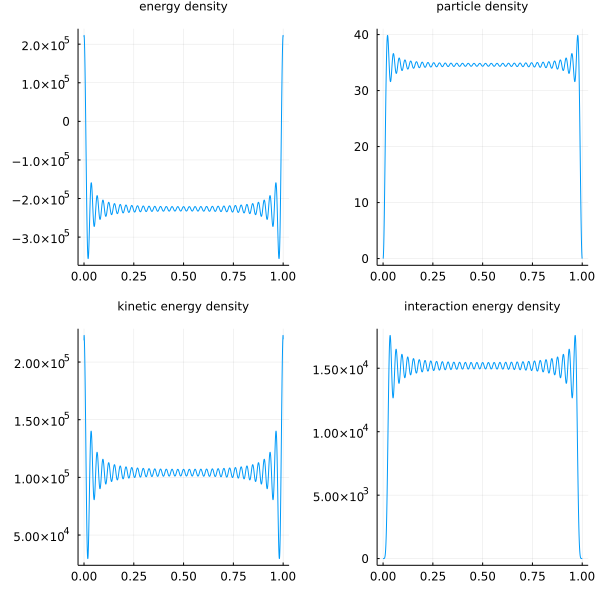

In [52]:
energy_density = expval(CMPSKit.density(Ĥ₁(μ=μ, g=g)), Ψ, ρL, ρR)
particle_density = expval(n̂, Ψ, ρL, ρR)
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g*û, Ψ, ρL, ρR)
plotgrid = 0:1/3200:1
p1 = plot(plotgrid, energy_density.(plotgrid), label = "", title = "energy density")
p2 = plot(plotgrid, particle_density.(plotgrid), label = "", title="particle density")
p3 = plot(plotgrid, kinetic_energy_density.(plotgrid), label = "", title = "kinetic energy density")
p4 = plot(plotgrid, interaction_energy_density.(plotgrid), label="", title="interaction energy density")
plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 8, size = (600, 600))

We observe strong Friedel oscillations resulting from the hard boundaries, which exist throughout the whole system. Note that the same pattern also manifests itself in the entanglement structure of the ground state, by considering a left-right bipartition of the system for various positions $0\leq x \leq 1$ of the cut.

In [53]:
entanglement_grid = 0:1/3200:1
spectra = sort.(real.(eigvals.((ρL*ρR).(entanglement_grid))), rev=true)
spectra_reorganized = [collect(s[i] for s in spectra) for i = 1:D]
entropy(spectrum) = sum(-abs(p)*log(abs(p)) for p in spectrum)
p1 = plot(entanglement_grid, spectra_reorganized,  yscale = :log10, label="", ylim = (1e-12,1), title = "entanglement spectra")
p2 = plot(entanglement_grid, entropy.(spectra),  label="", title = "entanglement entropy")
plot(p1, p2, layout = (1,2), titlefontsize = 8, size = (600, 300))

The location of the peaks, in particular in the particle density, can be interpreted as the location of the particles, which have strong tendency to be fixed on a lattice. In the thermodynamic limit, such a lattice cannot exist in one dimension without explicit breaking of translation symmetry by an external potential, but in a finite box the boundaries provide the required symmetry breaking. At the same time, compared to the infinite cMPS, the finite cMPS does preserve the $\mathsf{U}_1$ particle number symmetry very well. We can assess this by both computing the total particle number variance, as well as by again considering the order parameter for Bose-Einstein condensation and taking its maximal value in the interval $[a,b]$. 

In [54]:
@show N = expval(N̂, Ψ, ρL, ρR);
R, = Ψ.Rs
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2;
@show ΔN_relative = sqrt(ΔN²)/N
@show bec_order = maximum(abs.(expval(ψ̂, Ψ, ρL, ρR).(plotgrid)))
average_density = N/(b-a)
@show relative_bec_order = bec_order / sqrt(average_density);

N = expval(N̂, Ψ, ρL, ρR) = 33.99992574286643
ΔN² = (2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2 = 0.0006753739946816495
ΔN_relative = sqrt(ΔN²) / N = 0.0007643533943096587
bec_order = maximum(abs.((expval(ψ̂, Ψ, ρL, ρR)).(plotgrid))) = 0.0017417203811421495
relative_bec_order = bec_order / sqrt(average_density) = 0.0002987029072684821


Hence, this finite cMPS thus describes an almost exact eigenstate of the particle number operator with an eigenvalue of 34 particles, and very few fluctuations on top of that. The value of the order parameter for condensation is three orders of magnitude smaller than the one if the infinite cMPS.


Finally, we compute the "Casimir energy". With cMPS, this is easily given by

In [55]:
Eb = E - e∞[] * (b-a)

5663.793738989712

An exact result for the Casimir boundary energy from Bethe ansatz is only available for the case where the bulk (i.e. the size of the box) goes to infinity, and was only computed recently:
B. Reichert, G. E. Astrakharchik, A. Petković, and Z. Ristivojevic, Physical Review Letters 123, 250602 (2019).
https://doi.org/10.1103/PhysRevLett.123.250602

Given that we have two boundaries, we add an extra factor of two to the computation of the boundary energy $E_b$.

In [56]:
function bethe_with_boundary(g, q; N = 100)
    if iszero(q)
        return 0., 0., 1/pi, 0.
    end
    dk = 2*q/N
    kgrid = range(-q, stop = q, length = N+1)
    dkgrid = dk*vcat([0.5], ones(Float64, N-1), [0.5])
    M = I + (kernel.(g, kgrid, kgrid') .* dkgrid')/(2π)
    ρ = M\(ones(Float64, N+1)/(2π))
    dρ = M\((-1/(2π)) .* (kernel.(g, kgrid, q) .* ρ[N] .+ kernel.(g, kgrid, -q) .* ρ[1]))
    e = sum(kgrid.^2 .* ρ .* dkgrid)
    de = q^2*ρ[end] + q^2*ρ[1] + sum(kgrid.^2 .* dρ .* dkgrid)
    n = sum(ρ .* dkgrid)
    dn = ρ[end] + ρ[1] + sum(dρ .* dkgrid)
    g = M\(sign.(kgrid) ./ 4 .+ atan.(2 .* kgrid ./ g) ./ (2π))
    Eb = 2*sum(kgrid .* g .* dkgrid)
    return n, e, Eb, dn, de
end

bethe_with_boundary (generic function with 1 method)

In [57]:
n_bethe, e_bethe, Eb_bethe, = bethe_with_boundary(g, q_c; N = 2000);
@show Eb_bethe;

Eb_bethe = 5675.96915358059


These values match quite well, given that the Bethe ansatz result should only be valid in the thermodynamic limit.